In [2]:
import numpy as np
import cv2 as cv
from PIL import Image, ImageEnhance
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms,models
import matplotlib .pyplot as plt
from itertools import permutations
import os
import random

def rotate(x, degree):
    # Rotate the image by degrees counter clockwise
    return x.rotate(degree)

def enh_bri(x, brightness):
    bri = ImageEnhance.Brightness(x)
    return bri.enhance(brightness)

def enh_con(x, contrast):
    con = ImageEnhance.Contrast(x)
    return con.enhance(contrast)

def enh_sha(x, sharpness):
    sha = ImageEnhance.Sharpness(x)
    return sha.enhance(sharpness)

def gaussian(x, kernel_size):
    x = np.array(x)
    x = cv.GaussianBlur(x, kernel_size, sigmaX=0)
    return Image.fromarray(x)

def shear(x, shear_factor):
    # 定义错切变换矩阵
    shear_matrix = [1, shear_factor, 0, 0, 1, 0]

    # 创建Affine对象并应用错切变换
    sheared_img = x.transform(
        x.size, Image.Transform.AFFINE, shear_matrix
    )
    return sheared_img

def translate(x, shift):
    shift_x, shift_y = shift[0], shift[1]
    # 进行平移操作
    translated_img = x.transform(
        x.size, Image.Transform.AFFINE, (1, 0, shift_x, 0, 1, shift_y)
    )
    return translated_img

mrs = [rotate, enh_bri, enh_sha, enh_con, gaussian, shear, translate]
mrs_name =[mr.__name__ for mr in mrs]
print(mrs_name)
paras = [3, 0.8, 0.8, 0.8, (3, 3), 0.1, (1,1)]

['rotate', 'enh_bri', 'enh_sha', 'enh_con', 'gaussian', 'shear', 'translate']


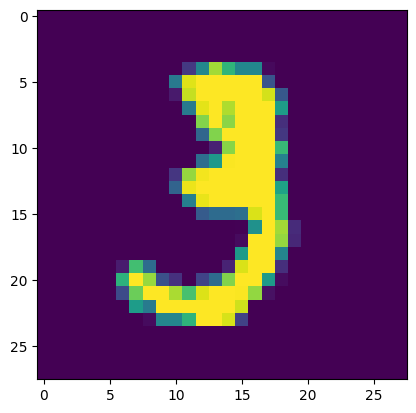

------------------------------------------------
<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>
rotate
PSNR 37.05662710743348
SSIM (0.9979528687491905, 0.9982398929373055)
CW-SSIM 0.9971323984036068
MS-SSIM (0.9998655644809136+0j)
uqi 0.9976049306282236
<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>
enh_bri
PSNR 22.941603830274268
SSIM (0.9518856087577667, 0.975597792377611)
CW-SSIM 0.9751284130493304
MS-SSIM (0.978534281930288+0j)
uqi 0.9563077977613762
<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>
enh_sha
PSNR 37.59374890411245
SSIM (0.998616446243357, 0.9987669763743912)
CW-SSIM 0.9907330157741433
MS-SSIM (0.9997553657185354+0j)
uqi 0.9318588510643403
<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>
enh_con
PSNR 23.729828867152488
SSIM (0.9475764014926361, 0.975689480145648)
CW-SSIM 0.8727166564162437
MS-SSIM (0.9784752352859211+0j)
uqi 0.8076359124291994
<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>
gaussian
PSNR 22.420909191044124
SSIM (0.9504397986800364,

In [3]:

import ssim.ssimlib as pyssim
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp

train_dataset = datasets.MNIST(root='./data', train=True, download=True)
x = train_dataset[10][0]
plt.imshow(x)
plt.show()
print('------------------------------------------------')
for i in range(len(mrs)):
    x = train_dataset[10][0]
    x_f = mrs[i](x, paras[i])
    print(type(x), type(x_f))
    print(mrs_name[i])
    print('PSNR', cv.PSNR(np.array(x), np.array(x_f)))
    print('SSIM', ssim(np.array(x), np.array(x_f)))
    print('CW-SSIM', pyssim.SSIM(x).cw_ssim_value(x_f))
    print('MS-SSIM', msssim(np.array(x), np.array(x_f)))
    print('uqi', uqi(np.array(x), np.array(x_f)))
    #plt.imshow(x_f)
    #plt.show()

In [ ]:
test_dataset = datasets.MNIST(root='./data', train=False, download=True)


result_msssim ={}
for i in range(len(mrs)):
    for cmr in permutations(range(len(mrs)),i+1):
        result_msssim[cmr] = []


for k in range(len(mrs)):
    for cmr in permutations(range(len(mrs)), k+1):
        followup_test_dataset = CustomDataset(test_dataset, cmr)
        valid_num = 0
        for i in range(len(test_dataset)):
            x = test_dataset[i][0]
            x_f = followup_test_dataset[i][0]
            result_msssim[cmr].append(msssim(np.array(x), np.array(x_f)))
        print(cmr)

In [9]:
### Test 2 images

test_dataset = datasets.MNIST(root='./data', train=False, download=True)


result_msssim ={}
for i in range(len(mrs)):
    for cmr in permutations(range(len(mrs)),i+1):
        result_msssim[cmr] = []


for k in range(len(mrs)):
    for cmr in permutations(range(len(mrs)), k+1):
        followup_test_dataset = CustomDataset(test_dataset, cmr)
        valid_num = 0
        for i in range(2):
            x = test_dataset[i][0]
            x_f = followup_test_dataset[i][0]
            result_msssim[cmr].append(msssim(np.array(x), np.array(x_f)))
        #print(cmr)
    print(k+1)

1
2
3
4
5


In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataset, cmr=None, transform=None):
        self.transform = transform
        self.data = []
        self.labels = []
        for idx, (img, label) in enumerate(dataset):
            if cmr is not None:
                for index in cmr:
                    img = mrs[index](img, paras[index])
            self.data.append(img)
            self.labels.append(label)
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data, label = self.data[idx], self.labels[idx]
        if self.transform is not None:
            data = self.transform(data)
        return data, label


In [2]:
# 定义变分自编码器（VAE）模型
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE, self).__init__()

        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, latent_size * 2)  # 输出均值和方差
        )

        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()  # 输出值范围在 [0, 1] 之间（因为MNIST像素值在 [0, 1]）
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # 编码
        latent_params = self.encoder(x)
        mu, logvar = latent_params[:, :latent_size], latent_params[:, latent_size:]
        z = self.reparameterize(mu, logvar)

        # 解码
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar

# 设定超参数和数据加载器
batch_size = 64
input_size = 28 * 28  # MNIST图像大小为28x28
hidden_size = 256
latent_size = 64
lr = 1e-3
epochs = 10

transform = transforms.Compose([transforms.ToTensor()])
train_set = datasets.MNIST('data', train=True, download=True, transform=transform)
test_set = datasets.MNIST('data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# 创建VAE模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_size, hidden_size, latent_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss(reduction='sum')


In [3]:
# 训练VAE模型
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, input_size).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        BCE = criterion(recon_batch, data)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = BCE + KLD
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader.dataset)}")

# 评估模型
model.eval()
test_loss = 0.0
with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
        data = data.view(-1, input_size).to(device)
        recon_batch, mu, logvar = model(data)
        test_loss += criterion(recon_batch, data).item()

test_loss /= len(test_loader.dataset)
print(f"Test set loss: {test_loss:.4f}")

Epoch 1/10, Loss: 49.08018544718424
Epoch 2/10, Loss: 37.9534951558431
Epoch 3/10, Loss: 34.01207551676432
Epoch 4/10, Loss: 32.69792815958659
Epoch 5/10, Loss: 31.928122278849283
Epoch 6/10, Loss: 31.301065319824218
Epoch 7/10, Loss: 30.775826279703775
Epoch 8/10, Loss: 30.455070864868166
Epoch 9/10, Loss: 30.15740827636719
Epoch 10/10, Loss: 29.918731955973307
Test set loss: 20.0118


<class 'PIL.Image.Image'>


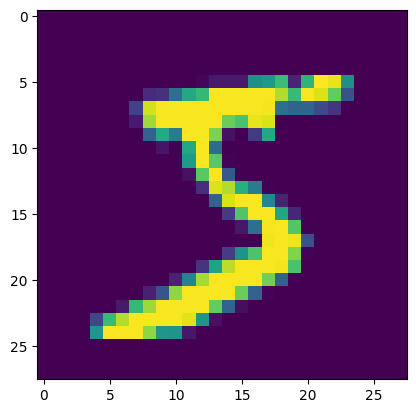

In [4]:
import matplotlib.pyplot as plt

train_dataset = datasets.MNIST(root='./data', train=True, download=True)
x = train_dataset[0][0]
plt.imshow(x)
print(type(x))


torch.Size([1, 28, 28])
torch.Size([1, 784])


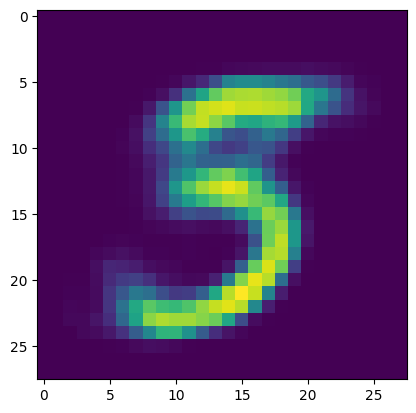

In [11]:
x = train_dataset[0][0]
x = transform(x)
print(x.shape)
x_r = x.view(-1, input_size)
print(x_r.shape)
x_r = model(x_r.to(device))
t = x_r[0].cpu()
t = t.view(28,28)
plt.imshow(t.detach().numpy())

In [8]:
import numpy as np
from scipy.stats import gamma

#将训练集的误差存起来
error_training = np.zeros(len(train_set))
train_loader = DataLoader(train_set, batch_size=1, shuffle=False)
model.to(device)
model.eval()
with torch.no_grad():
    for i, (data, _) in enumerate(train_loader):
        data = data.view(-1, input_size).to(device)
        recon_batch, _, _ = model(data)
        error_training[i] = criterion(recon_batch, data).item()


#拟合一个分布
shape, loc, scale = gamma.fit(error_training, floc=0)
false_alarm = 0.001

#求出上百分之一分位数
threshold = gamma.ppf(1-false_alarm, shape, loc, scale)

#将测试集放进去，看看是不是全部通过
error_testing = np.zeros(len(test_set))
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
        data = data.view(-1, input_size).to(device)
        recon_batch, _, _ = model(data)
        error_testing[i] = criterion(recon_batch, data).item()

print(np.where(error_training>threshold)[0].size)
print(np.where(error_testing>threshold)[0].size)



24
5


In [15]:
print(threshold)
input_size = 28*28
image_black = torch.zeros(28,28).to(device)
recon_batch, _, _ = model(image_black.view(-1, input_size))
error = criterion(recon_batch, image_black).item()

64.77249883389156


/home/husy/anaconda3/envs/cmr/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([28, 28])) that is different to the input size (torch.Size([1, 784])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (784) must match the size of tensor b (28) at non-singleton dimension 1

In [18]:
class MNISTFOLLOWUP(Dataset):
    def __init__(self, mnist_dataset, cmr, transform=None):
        self.transform = transform
        self.data = []
        self.labels = []
        for idx, (img, label) in enumerate(mnist_dataset):
            for index in cmr:
                img = mrs[index](img, paras[index])
            self.data.append(img)
            self.labels.append(label)
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.transform is not None:
            self.data[idx] = self.transform(self.data[idx])
        return self.data[idx], self.labels[idx]



mnist_testset = datasets.MNIST(root='./data', train=False, download=True)
for k in [4]: 
    k = k+1
    for p in permutations(range(len(mrs)), k):
        print(p)

        temp = np.zeros(len(mnist_testset))
        dateset_followup = MNISTFOLLOWUP(mnist_dataset=mnist_testset, cmr=p, transform=transform)
        testload_followup = torch.utils.data.DataLoader(dateset_followup, batch_size=1, shuffle=False)
        with torch.no_grad():
            for i,(X,y) in enumerate(testload_followup):
                X = X.view(-1, input_size).to(device)
                recon_batch, _, _ = model(X)
                temp[i] = criterion(recon_batch, X).item()
                
        print(np.where(temp>threshold)[0].size/len(mnist_testset))

(0, 1, 2, 3, 4)
0.0
(0, 1, 2, 3, 5)


KeyboardInterrupt: 

In [3]:
print(len(list(permutations(range(len(mrs)),3))))

210


In [55]:


class MNISTFOLLOWUP(Dataset):
    def __init__(self, mnist_dataset, cmr, transform=None):
        self.transform = transform
        self.data = []
        self.labels = []
        for idx, (img, label) in enumerate(mnist_dataset):
            for index in cmr:
                img = mrs[index](img, paras[index])
            self.data.append(img)
            self.labels.append(label)
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.transform is not None:
            self.data[idx] = self.transform(self.data[idx])
        return self.data[idx], self.labels[idx]

from skimage.metrics import structural_similarity as ssim
transform = transforms.Compose([transforms.ToTensor()])
mnist_testset = datasets.MNIST(root='./data', train=False, download=True)
for k in range(2): 
    k = k+1
    for p in permutations(range(len(mrs)), k):
        print(p)
        ssim_total = 0
        dataset_followup = MNISTFOLLOWUP(mnist_dataset=mnist_testset, cmr=p, transform=transform)
        #print(type(dataset_followup[0][0].numpy()),'11')
        for i in range(len(mnist_testset)):
            img1 = transform(mnist_testset[i][0]).numpy().squeeze()
            img2 = dataset_followup[i][0].numpy().squeeze()
            ssim_total += ssim(img1, img2, data_range=1)
        print(ssim_total/len(mnist_testset))

(0,)
0.9860378665496065
(1,)
0.9630546596526117
(2,)
0.9938322675889176
(3,)
0.7753557587952193
(4,)
0.8877162493930575
(5,)
0.5461778418099702
(6,)
0.49593342389433165
(0, 1)
0.9507357471187253
(0, 2)
0.9807988696923985
(0, 3)
0.764467301579799
(0, 4)
0.8810492889567196
(0, 5)
0.5479129522477735
(0, 6)
0.5011221770276363
(1, 0)
0.9507357471187253
(1, 2)
0.9531640359300599
(1, 3)
0.7280508366575045
(1, 4)
0.8394674898122727
(1, 5)
0.5357793011449284
(1, 6)
0.4872555749446542
(2, 0)
0.9804037362447733
(2, 1)
0.953447904356755
(2, 3)
0.7643468751568133
(2, 4)
0.8736565872018668
(2, 5)
0.5507477265465768
(2, 6)
0.5037776290188141
(3, 0)
0.7653113170967254
(3, 1)
0.7368561537719397
(3, 2)
0.7640119210839791
(3, 4)
0.6732627485505763
(3, 5)
0.4039131233690694
(3, 6)
0.35396142913558726
(4, 0)
0.8788305759825583
(4, 1)
0.8403258517378613
(4, 2)
0.8743638889341937
(4, 3)
0.6731568935806268
(4, 5)
0.5576015439645042
(4, 6)
0.534904215965643
(5, 0)
0.547327519630633
(5, 1)
0.5357793011449284
(5

In [49]:
from skimage.metrics import structural_similarity as ssim
from torchvision import datasets, transforms

# 加载 MNIST 数据集
transform = transforms.Compose([transforms.ToTensor()])
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# 选择两个图像的索引进行比较
index1 = 0  # 第一个图像的索引
index2 = 1  # 第二个图像的索引

# 获取两个图像数据
img1 = mnist_testset[index1][0].numpy()
img2 = mnist_testset[index2][0].numpy()

# 计算 SSIM
ssim_value, _ = ssim(img1, img2, full=True)

print(f"SSIM value between image{index1} and image{index2}: {ssim_value}")

ValueError: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.

### RQ1

[[14, 15, 4, 13, 68, 64, 87], [25, 18, 19, 75, 67, 120, 25, 26, 48, 155, 66, 105, 18, 26, 20, 75, 61, 94, 19, 48, 20, 134, 65, 99, 83, 152, 75, 131, 121, 152, 62, 66, 61, 65, 120, 263, 107, 105, 94, 100, 152, 252], [37, 56, 156, 69, 126, 37, 33, 89, 69, 116, 57, 33, 137, 68, 125, 155, 89, 140, 124, 163, 69, 68, 68, 124, 298, 126, 116, 125, 163, 324, 37, 56, 156, 69, 126, 38, 56, 200, 73, 108, 56, 54, 494, 98, 128, 168, 200, 492, 229, 255, 67, 71, 98, 228, 279, 113, 108, 128, 256, 273, 38, 34, 90, 69, 123, 38, 56, 197, 74, 108, 34, 55, 168, 69, 107, 91, 198, 170, 127, 157, 65, 74, 69, 134, 262, 115, 108, 107, 157, 259, 57, 33, 137, 68, 125, 57, 55, 493, 98, 130, 33, 56, 168, 68, 108, 147, 491, 169, 204, 231, 65, 98, 69, 201, 274, 107, 130, 108, 230, 266, 164, 93, 149, 125, 168, 164, 198, 490, 230, 255, 95, 197, 170, 127, 156, 149, 491, 170, 205, 230, 123, 230, 128, 205, 349, 157, 255, 156, 230, 344, 67, 65, 65, 125, 276, 67, 71, 98, 228, 279, 64, 74, 68, 135, 262, 65, 98, 69, 202, 274, 

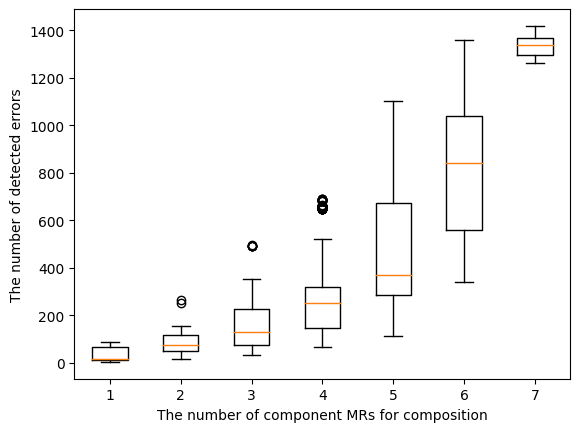

7
42
210
840
2520
5040
5040


In [8]:
import matplotlib.pyplot as plt
import numpy as np

mrs = [0]*7

data = [[] for _ in range(len(mrs))]
pred_source = np.load('predictions/MNIST_AlexNet_9938_source.npy')
pred_followup = np.load('predictions/MNIST_AlexNet_9938_followup.npy',allow_pickle=True).item()

def error_detection(mr):
    return (pred_followup[mr]!=pred_source).sum()

for mr in pred_followup.keys():
    data[len(mr)-1].append(error_detection(mr))
print(data)

# 创建箱线图
plt.boxplot(data, patch_artist=False)

# 设置图表标题和轴标签
#plt.title('Boxplot Example')
plt.xlabel('The number of component MRs for composition')
plt.ylabel('The number of detected errors')

# 显示图表
plt.show()

for i in range(len(mrs)):
    print(len(data[i]))

In [1]:
from matplotlib_venn import venn7
import matplotlib.pyplot as plt

# 创建7个集合的数据
sets = (
    "1000000", "0100000", "0010000", "0001000", "0000100", "0000010", "0000001"
)

# 绘制韦恩图
venn7(subsets=sets, set_labels=('A', 'B', 'C', 'D', 'E', 'F', 'G'))

# 设置图表标题
plt.title("7-set Venn Diagram")

# 显示图表
plt.show()

ImportError: cannot import name 'venn7' from 'matplotlib_venn' (/home/husy/anaconda3/envs/cmr/lib/python3.8/site-packages/matplotlib_venn/__init__.py)

In [74]:
import matplotlib.pyplot as plt
from matplotlib_venn._venn7 import _compute_venn7_subsets
from itertools import product

def venn7(subsets, set_labels=None):
    if set_labels is None:
        set_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

    if len(subsets) != 7:
        raise ValueError("Exactly 7 subsets are required for a Venn diagram.")

    venn_subsets = _compute_venn7_subsets(*subsets)
    plt.figure(figsize=(8, 8))
    venn_names = ["".join(str(b) for b in binary) for binary in product([0, 1], repeat=7)]
    venn = plt.subplot()

    for idx, subset in enumerate(venn_names):
        venn.text(venn_subsets[idx][0], venn_subsets[idx][1], subset, ha='center', va='center')

    venn.set_xticks([])
    venn.set_yticks([])
    venn.set_title('7-Set Venn Diagram')
    venn.set_xlabel("\n".join(set_labels))

    plt.show()

# 7个集合的数据
subsets = (
    1, 1, 1, 1, 1, 1, 1,  # 1111111
    0, 1, 1, 1, 1, 1, 1,  # 0111111
    1, 0, 1, 1, 1, 1, 1,  # 1011111
    # ... 这里省略了其余组合的集合数据
    0, 0, 0, 0, 0, 0, 0   # 0000000
)

venn7(subsets)


ModuleNotFoundError: No module named 'matplotlib_venn._venn7'